<h2>Exercise 11: Deep learning, dense neural networks, continuous predictors<h2>

<h5>11-1: try varying the number of training data, the number of training epochs and the noise intensity in the 1 node network defined in LNS_Exercise11<h5>

We start with some definitions. one of them is a class for generating and storing random noised data out of function

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
import time

class FunctionData:
    def __init__ (self, function, parameters, limits, ntrain, ntest, noise_sigma, ndims:int =1):
        np.random.seed(0)
        self.function = function
        self.parameters = parameters
        self.limits = limits
        
        if ndims == 1:
            self.xtrain = np.random.uniform (limits[0], limits[1], ntrain) 
            self.xtest = np.random.uniform (limits[0], limits[1], ntest) 
            
            self.ytrain = np.random.normal (function (self.xtrain, parameters), noise_sigma) 
            self.ytest = np.random.normal (function (self.xtest, parameters), noise_sigma) 
            
        
        elif ndims > 1:
            self.xtrain = np.array([np.random.uniform (limits[0], limits[1], int (ntrain / ndims)) 
                                    for idim in range (ndims)])
            self.xtest = np.array([np.random.uniform (limits[0], limits[1], int (ntest/ ndims)) 
                                   for idim in range (ndims)])

            self.ytrain = np.random.normal (function (self.xtrain, parameters), noise_sigma)
            self.ytest = np.random.normal (function (self.xtest, parameters), noise_sigma)
            
        
        
       
    def plot (self, which: str, showtarget:bool = True):
        if which == "train":
            plt.scatter (self.xtrain, self.ytrain, color="red", marker_sizelabel="training data")
        elif which == "test":
            plt.scatter (self.xtest, self.ytest, color="red", label="validation data")
        else:
            raise ValueError ("\"which\" argument must be either \"train\" or \"test\"")
        
        if showtarget == True:
            x = np.linspace(self.limits[0],self.limits[1], 200)
            plt.plot (x, self.function (x, self.parameters), label="target")
            
        plt.grid(True)
        plt.legend()
        plt.show()
        
    def target_y (self) :
        return self.function (self.xtest, self.parameters)
            
        
    

In [7]:
# import Keras library
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects


We define a "linear" callable to pass to FunctionData instances for generating data, and we define a model.

In [8]:
def linear (x, pars):
    return pars[0] + pars[1] * x

#target parameters
q = 1.
m = 2.
limits = [-1,1]

In [9]:
model = tf.keras.Sequential(
    Dense(1,input_shape=(1,))
)
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [10]:
model.summary()
model.save_weights ("model_lin")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


We try feeding the model datasets with different amounts of training data, and plot the results

In [11]:
#try different values of number of training data, noise
lin_given_example = FunctionData (linear, [q,m], limits, 500, 50, 0.5)

ntrains = [50, 500, 5000, 50000]
noises = [0, 0.2, 0.5, 0.9, 1.5]

lin_change_ntrain = []
for n in ntrains:
    lin_change_ntrain.append (FunctionData (linear, [q,m], limits, n, 50, 0.5))

lin_change_noise = []
for noise in noises:
    lin_change_noise.append (FunctionData (linear, [q,m], limits, 500, 50, noise))


In [12]:
#change n° of training data

losses = []
accuracies = []
parameters = []

nEpochs = 30

for dataset in lin_change_ntrain: 
    model.load_weights ("model_lin")
    history=model.fit(x=dataset.xtrain, y=dataset.ytrain, 
          batch_size=32, epochs=nEpochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(dataset.xtest, dataset.ytest))
    parameters.append (model.get_weights())
    score = model.evaluate(dataset.xtest, dataset.ytest, batch_size=32, verbose=0)
    
    losses.append (history.history ["loss"])
    accuracies.append (history.history ["val_loss"])
    
    


    

Epoch 1/30
2/2 [==============================] - 0s 69ms/step - loss: 1.8463 - mse: 1.8463 - val_loss: 0.9679 - val_mse: 0.9679
Epoch 2/30
2/2 [==============================] - 0s 16ms/step - loss: 1.7219 - mse: 1.7219 - val_loss: 0.8901 - val_mse: 0.8901
Epoch 3/30
2/2 [==============================] - 0s 8ms/step - loss: 1.6081 - mse: 1.6081 - val_loss: 0.8186 - val_mse: 0.8186
Epoch 4/30
2/2 [==============================] - 0s 16ms/step - loss: 1.5023 - mse: 1.5023 - val_loss: 0.7553 - val_mse: 0.7553
Epoch 5/30
2/2 [==============================] - 0s 4ms/step - loss: 1.4069 - mse: 1.4069 - val_loss: 0.6977 - val_mse: 0.6977
Epoch 6/30
2/2 [==============================] - 0s 8ms/step - loss: 1.3217 - mse: 1.3217 - val_loss: 0.6481 - val_mse: 0.6481
Epoch 7/30
2/2 [==============================] - 0s 8ms/step - loss: 1.2422 - mse: 1.2422 - val_loss: 0.6005 - val_mse: 0.6005
Epoch 8/30
2/2 [==============================] - 0s 8ms/step - loss: 1.1668 - mse: 1.1668 - val_loss

Epoch 4/30
157/157 [==============================] - 0s 646us/step - loss: 0.2441 - mse: 0.2441 - val_loss: 0.2913 - val_mse: 0.2913
Epoch 5/30
157/157 [==============================] - 0s 639us/step - loss: 0.2440 - mse: 0.2440 - val_loss: 0.2876 - val_mse: 0.2876
Epoch 6/30
157/157 [==============================] - 0s 626us/step - loss: 0.2439 - mse: 0.2439 - val_loss: 0.2937 - val_mse: 0.2937
Epoch 7/30
157/157 [==============================] - 0s 639us/step - loss: 0.2440 - mse: 0.2440 - val_loss: 0.2889 - val_mse: 0.2889
Epoch 8/30
157/157 [==============================] - 0s 638us/step - loss: 0.2440 - mse: 0.2440 - val_loss: 0.2892 - val_mse: 0.2892
Epoch 9/30
157/157 [==============================] - 0s 738us/step - loss: 0.2441 - mse: 0.2441 - val_loss: 0.2922 - val_mse: 0.2922
Epoch 10/30
157/157 [==============================] - 0s 738us/step - loss: 0.2441 - mse: 0.2441 - val_loss: 0.2860 - val_mse: 0.2860
Epoch 11/30
157/157 [==============================] - 0s 539

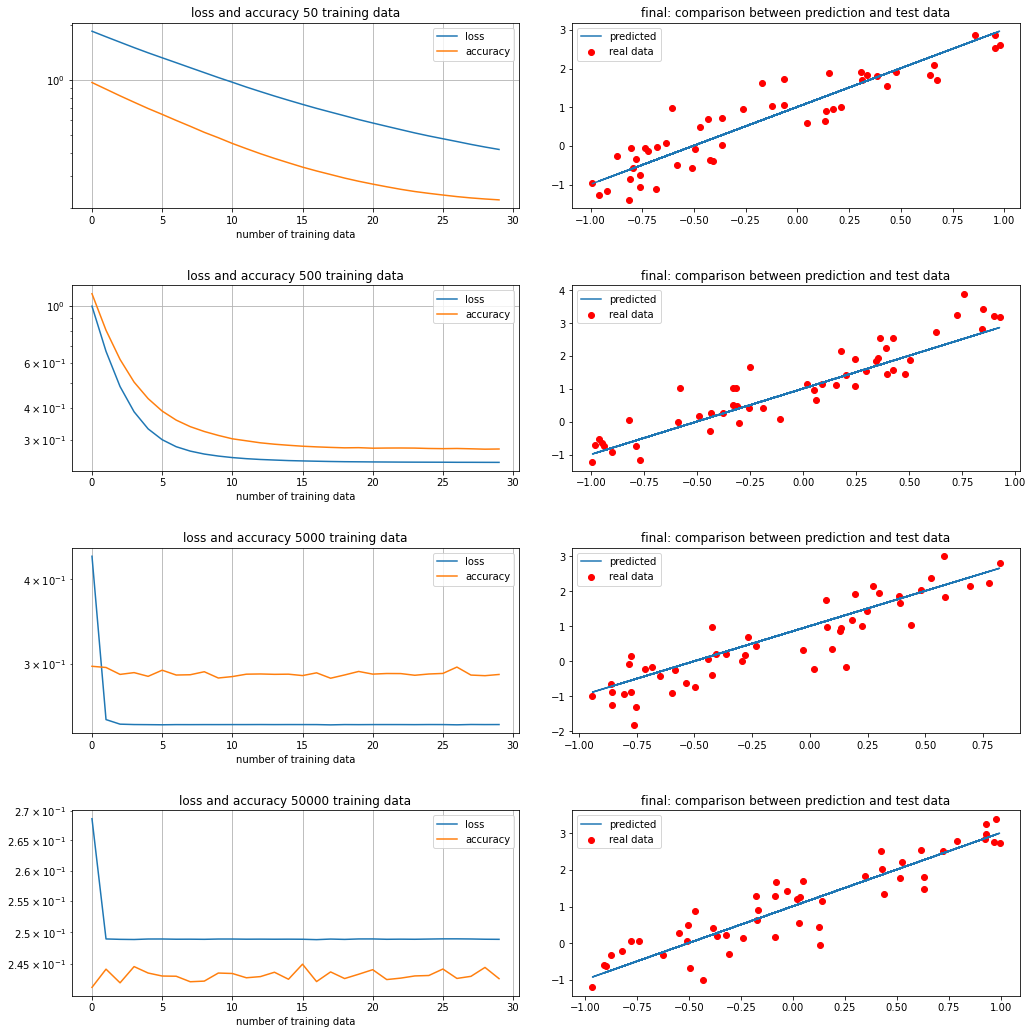

In [13]:
fig, axes = plt.subplots (len (ntrains),2)

for ax, loss, accuracy, ntrain, param, dataset in zip (axes, losses, accuracies, ntrains, parameters, lin_change_ntrain):
    ax[0].plot (range(nEpochs), loss, label="loss" )
    ax[0].plot (range(nEpochs), accuracy, label="accuracy")
    
    ax[0].set_title ("loss and accuracy " + str (ntrain) + " training data")
    ax[0].set_xlabel ("number of training data")
    ax[0].set_yscale ("log")
    ax[0].grid (True)
    ax[0].legend()
    
    ax [1].plot (dataset.xtest, model.predict (dataset.xtest), label="predicted")
    ax [1].scatter (dataset.xtest, dataset.ytest, color="red", label="real data")
    ax [1].set_title ("final: comparison between prediction and test data")
    ax [1].legend()

fig.set_size_inches ((15, 15))
fig.tight_layout (pad=3.0)

plt.show()

As expected, accuracy increases with more training data. When the data are very much, indeed, the model becomes soo good it that the performance on test data beat those on training data (which probably happens every time the sample of training data is much  more numerous than test data)

Next, we try different intensities of gaussian noise:

In [14]:
#change  noise intensity

losses = []
accuracies = []
parameters = []

nEpochs = 30

for dataset in lin_change_noise: 
    model.load_weights ("model_lin")
    history=model.fit(x=dataset.xtrain, y=dataset.ytrain, 
          batch_size=32, epochs=nEpochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(dataset.xtest, dataset.ytest))
    parameters.append (model.get_weights())
    score = model.evaluate(dataset.xtest, dataset.ytest, batch_size=32, verbose=0)
    
    losses.append (history.history ["loss"])
    accuracies.append (history.history ["val_loss"])
    
    

Epoch 1/30
16/16 [==============================] - 0s 4ms/step - loss: 0.8193 - mse: 0.8193 - val_loss: 0.5504 - val_mse: 0.5504
Epoch 2/30
16/16 [==============================] - 0s 2ms/step - loss: 0.4497 - mse: 0.4497 - val_loss: 0.3010 - val_mse: 0.3010
Epoch 3/30
16/16 [==============================] - 0s 1ms/step - loss: 0.2512 - mse: 0.2512 - val_loss: 0.1685 - val_mse: 0.1685
Epoch 4/30
16/16 [==============================] - 0s 2ms/step - loss: 0.1443 - mse: 0.1443 - val_loss: 0.0975 - val_mse: 0.0975
Epoch 5/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0858 - mse: 0.0858 - val_loss: 0.0583 - val_mse: 0.0583
Epoch 6/30
16/16 [==============================] - 0s 1ms/step - loss: 0.0530 - mse: 0.0530 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 7/30
16/16 [==============================] - 0s 976us/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 8/30
16/16 [==============================] - 0s 2ms/step - loss: 0.0233 - mse: 0.

Epoch 2/30
16/16 [==============================] - 0s 2ms/step - loss: 0.6625 - mse: 0.6625 - val_loss: 0.8021 - val_mse: 0.8021
Epoch 3/30
16/16 [==============================] - 0s 2ms/step - loss: 0.4834 - mse: 0.4834 - val_loss: 0.6171 - val_mse: 0.6171
Epoch 4/30
16/16 [==============================] - 0s 976us/step - loss: 0.3853 - mse: 0.3853 - val_loss: 0.5054 - val_mse: 0.5054
Epoch 5/30
16/16 [==============================] - 0s 1ms/step - loss: 0.3313 - mse: 0.3313 - val_loss: 0.4343 - val_mse: 0.4343
Epoch 6/30
16/16 [==============================] - 0s 2ms/step - loss: 0.3003 - mse: 0.3003 - val_loss: 0.3887 - val_mse: 0.3887
Epoch 7/30
16/16 [==============================] - 0s 2ms/step - loss: 0.2818 - mse: 0.2818 - val_loss: 0.3576 - val_mse: 0.3576
Epoch 8/30
16/16 [==============================] - 0s 977us/step - loss: 0.2707 - mse: 0.2707 - val_loss: 0.3373 - val_mse: 0.3373
Epoch 9/30
16/16 [==============================] - 0s 1ms/step - loss: 0.2636 - mse: 

16/16 [==============================] - 0s 2ms/step - loss: 2.3427 - mse: 2.3427 - val_loss: 2.9493 - val_mse: 2.9493
Epoch 5/30
16/16 [==============================] - 0s 976us/step - loss: 2.2944 - mse: 2.2944 - val_loss: 2.8111 - val_mse: 2.8111
Epoch 6/30
16/16 [==============================] - 0s 2ms/step - loss: 2.2633 - mse: 2.2633 - val_loss: 2.7158 - val_mse: 2.7158
Epoch 7/30
16/16 [==============================] - 0s 1ms/step - loss: 2.2456 - mse: 2.2456 - val_loss: 2.6554 - val_mse: 2.6554
Epoch 8/30
16/16 [==============================] - 0s 2ms/step - loss: 2.2325 - mse: 2.2325 - val_loss: 2.6113 - val_mse: 2.6113
Epoch 9/30
16/16 [==============================] - 0s 976us/step - loss: 2.2261 - mse: 2.2261 - val_loss: 2.5858 - val_mse: 2.5858
Epoch 10/30
16/16 [==============================] - 0s 976us/step - loss: 2.2211 - mse: 2.2211 - val_loss: 2.5538 - val_mse: 2.5538
Epoch 11/30
16/16 [==============================] - 0s 1ms/step - loss: 2.2155 - mse: 2.2155 

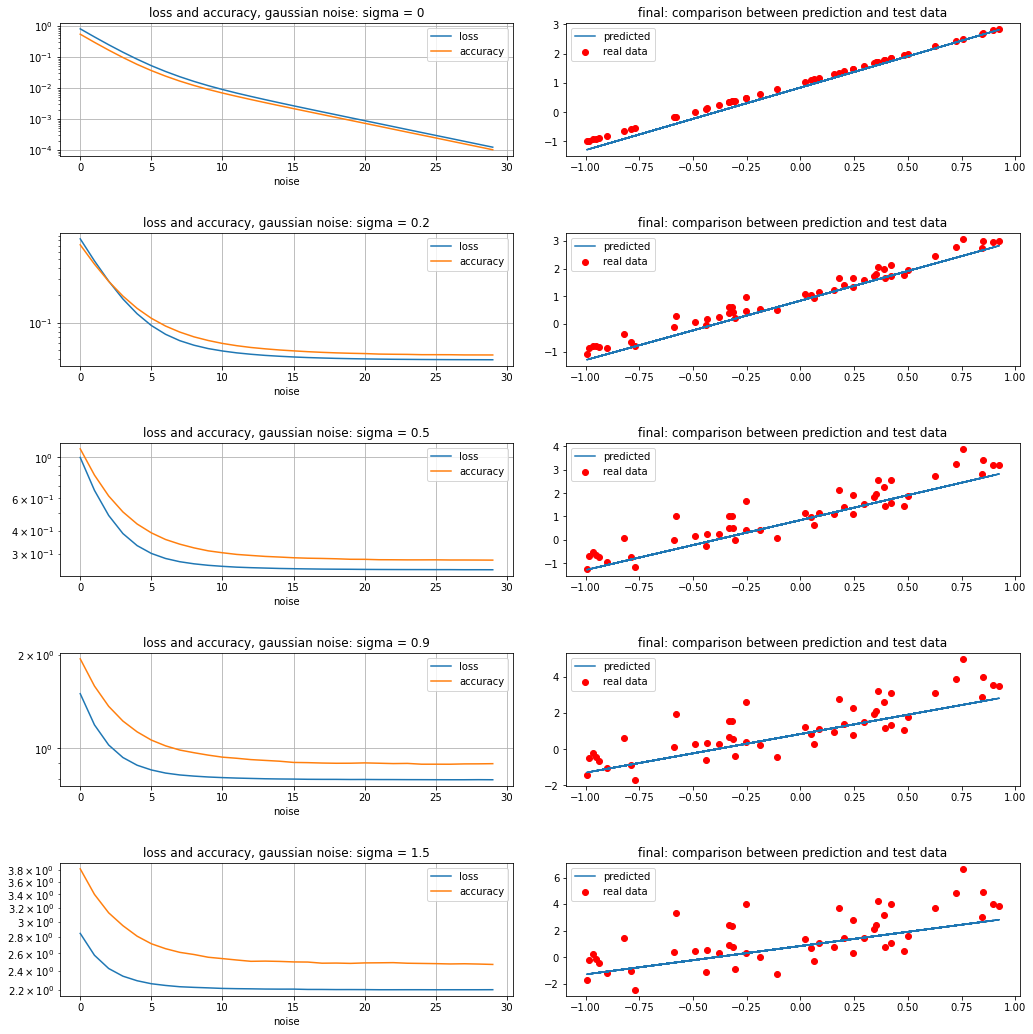

In [15]:
fig, axes = plt.subplots (len (noises),2)

for ax, loss, accuracy, noise, param, dataset in zip (axes, losses, accuracies, noises, parameters, lin_change_noise):
    ax[0].plot (range(30), loss, label="loss" )
    ax[0].plot (range(30), accuracy, label="accuracy")
    
    ax[0].set_title ("loss and accuracy, gaussian noise: sigma = " + str (noise))
    ax[0].set_xlabel ("noise")
    ax[0].set_yscale ("log")
    ax[0].grid (True)
    ax[0].legend()
    
    
    ax [1].plot (dataset.xtest, model.predict (dataset.xtest), label="predicted")
    ax [1].scatter (dataset.xtest, dataset.ytest, color="red", label="real data")
    ax [1].set_title ("final: comparison between prediction and test data")
    ax [1].legend()

fig.set_size_inches ((15, 15))
fig.tight_layout (pad=3.0)

plt.show()

As expected, noise intensity greatly affects accuracy: the noise varying from 0.2 to 1.5 raises the loss on test data of about 100 times.

Now we plot the results for varying number of epochs

In [16]:
#plot loss and accuracy as a function of number of epochs

nEpochs = 45

#define callback for saving weigths at each epoch
class SavePredictions (tf.keras.callbacks.Callback):
    def __init__ (self, xdata):
        self.xdata = xdata
        self.ydata = []
        
    def on_epoch_end (self, epoch, logs={}):
        self.ydata.append (self.model.predict (self.xdata))
        
save_predictions = SavePredictions (lin_given_example.xtest)
    
model.load_weights ("model_lin")
history=model.fit(x=lin_given_example.xtrain, y=lin_given_example.ytrain, 
      batch_size=32, epochs=nEpochs,
      shuffle=True, # a good idea is to shuffle input before at each epoch
      validation_data=(lin_given_example.xtest, lin_given_example.ytest), 
      callbacks=[save_predictions])

loss = history.history ["loss"]
accuracy = history.history ["val_loss"]






Epoch 1/45
16/16 [==============================] - 0s 6ms/step - loss: 0.9990 - mse: 0.9990 - val_loss: 1.1141 - val_mse: 1.1141
Epoch 2/45
16/16 [==============================] - 0s 4ms/step - loss: 0.6624 - mse: 0.6624 - val_loss: 0.7979 - val_mse: 0.7979
Epoch 3/45
16/16 [==============================] - 0s 4ms/step - loss: 0.4812 - mse: 0.4812 - val_loss: 0.6156 - val_mse: 0.6156
Epoch 4/45
16/16 [==============================] - 0s 4ms/step - loss: 0.3847 - mse: 0.3847 - val_loss: 0.5039 - val_mse: 0.5039
Epoch 5/45
16/16 [==============================] - 0s 4ms/step - loss: 0.3303 - mse: 0.3303 - val_loss: 0.4335 - val_mse: 0.4335
Epoch 6/45
16/16 [==============================] - 0s 4ms/step - loss: 0.2995 - mse: 0.2995 - val_loss: 0.3869 - val_mse: 0.3869
Epoch 7/45
16/16 [==============================] - 0s 4ms/step - loss: 0.2813 - mse: 0.2813 - val_loss: 0.3572 - val_mse: 0.3572
Epoch 8/45
16/16 [==============================] - 0s 4ms/step - loss: 0.2705 - mse: 0.27

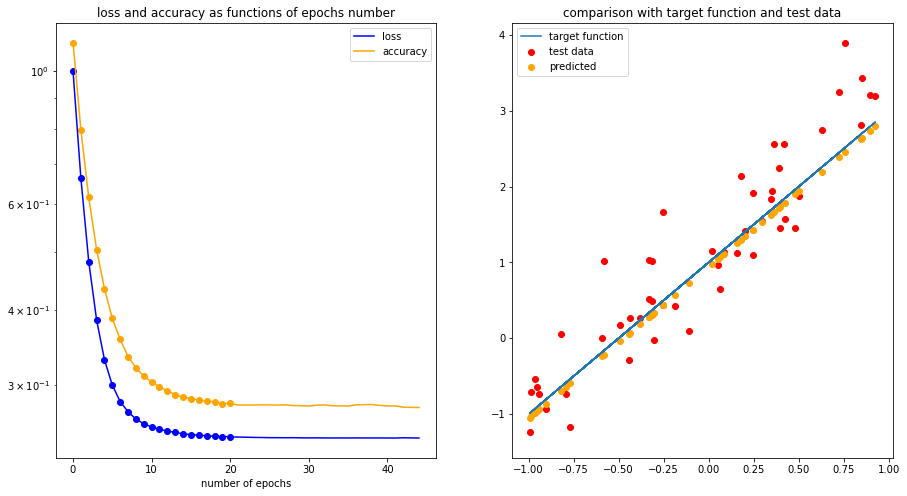

In [17]:
from IPython import display
import time
#%matplotlib

fig, axes = plt.subplots (1,2)
fig.set_size_inches (15, 8)

axes [0].set_title ("loss and accuracy as functions of epochs number")
axes [0].plot (range ( len(loss)), loss, color="blue", label="loss")
axes [0].plot (range ( len(accuracy)), accuracy, color="orange", label="accuracy")
axes [0].set_xlabel ("number of epochs")
axes [0].set_yscale ("log")

axes [1].set_title ("comparison with target function and test data")
axes [1].scatter (lin_given_example.xtest, lin_given_example.ytest, color="red", label="test data")
axes [1].plot (lin_given_example.xtest, lin_given_example.target_y (), label="target function")


for ind, (lo, acc, pred) in enumerate (zip (loss, accuracy, save_predictions.ydata)):       
    try:
        axes [0].scatter (ind, lo, color="blue")
        axes [0].scatter (ind, acc, color="orange")
        axes [0].legend()
        
        axes [1].scatter (save_predictions.xdata, pred, color="orange", label="predicted")
        axes [1].legend()
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.1)
        axes [1].collections [1].remove()
    except KeyboardInterrupt:
        break
        
    


It can be seen that after about epoch 30 there is no more significant improvement in the in the loss estimates nor in the parameters; indeed, in the end the model becomes slightly overfitting 

<h5>11-2: try and make a continuous predictor for a $\mathbb{R} \to \mathbb{R}$ poynomial function. Try different optimizers, activations and cost functions<h5>

We start by creating train/test data: 

In [20]:
# target parameters of f(x) = a0 + a1*x^1 + a2*x^2 + a3*x^3
a0 = 4
a1 = -3
a2 = -2
a3 = 3

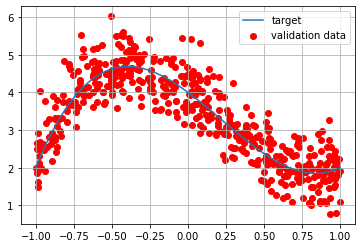

In [21]:
def polynomial (x, pars):
    return pars[0] + pars[1] * x + pars[2] * (x**2) + pars[3] * (x**3)

datapol = FunctionData( polynomial, [a0,a1,a2,a3], [-1,1], 5000, 500, noise_sigma=0.5)

datapol.plot ("test", True)

newx_test = np.random.uniform (-2,2, 500)
newy_test = polynomial (newx_test,[a0,a1,a2,a3])


Testing models with different number of layers and number of nodes for each layer, all of them with optimizer = ADAM, activation = ReLU, loss = MSE

In [22]:


losses = []
val_losses = []
predictions = []

sizes = [2,4,8,16,32]
depths = range (5)

x_pred = np.linspace (-1,1, 100)
for nhiddlayers in depths:
    looploss = []
    loopval_loss = []
    looppred = []
    for ind, size in enumerate (sizes):
        model_pol = tf.keras.Sequential ()
        model_pol.add (Dense (size, input_shape=(1,), activation=activations.relu))
        for i in range (nhiddlayers):
            model_pol.add (Dense (size, activation=activations.relu))
        model_pol.add (Dense (1, activation=activations.relu))
        model_pol.compile (optimizer="adam", loss="mse", metrics=["mse"])
        model_pol.summary()
        
        history = model_pol.fit(x=datapol.xtrain, y=datapol.ytrain, 
                      batch_size=32, epochs=30,
                      shuffle=True, # a good idea is to shuffle input before at each epoch
                      validation_data=(datapol.xtest, datapol.ytest), verbose=1)
        looploss.append (history.history ["loss"])
        loopval_loss.append (history.history ["val_loss"])
        looppred.append (model_pol.predict (datapol.xtest))
        
        
    losses.append (looploss)
    val_losses.append (loopval_loss)
    predictions.append (looppred)
    



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1563/1563 [==============================] - 1s 735us/step - loss: 3.5738 - mse: 3.5738 - val_loss: 0.7802 - val_mse: 0.7802
Epoch 2/30
1563/1563 [==============================] - 1s 675us/step - loss: 0.8205 - mse: 0.8205 - val_loss: 0.7769 - val_mse: 0.7769
Epoch 3/30
1563/1563 [==============================] - 1s 661us/step - loss: 0.8199 - mse: 0.8199 - val_loss: 0.7762 - val_mse: 0.7762
Epoch 4/30
1563/1563 [==============================] - 1s 749us/step - loss: 0.8198 - mse: 0.8198 - val_loss: 0.7

1563/1563 [==============================] - 1s 665us/step - loss: 0.8202 - mse: 0.8202 - val_loss: 0.7791 - val_mse: 0.7791
Epoch 23/30
1563/1563 [==============================] - 1s 671us/step - loss: 0.8201 - mse: 0.8201 - val_loss: 0.7752 - val_mse: 0.7752
Epoch 24/30
1563/1563 [==============================] - 1s 661us/step - loss: 0.8201 - mse: 0.8201 - val_loss: 0.7784 - val_mse: 0.7784
Epoch 25/30
1563/1563 [==============================] - 1s 641us/step - loss: 0.8203 - mse: 0.8203 - val_loss: 0.7816 - val_mse: 0.7816
Epoch 26/30
1563/1563 [==============================] - 1s 665us/step - loss: 0.8204 - mse: 0.8204 - val_loss: 0.7759 - val_mse: 0.7759
Epoch 27/30
1563/1563 [==============================] - 1s 641us/step - loss: 0.8200 - mse: 0.8200 - val_loss: 0.7757 - val_mse: 0.7757
Epoch 28/30
1563/1563 [==============================] - 1s 642us/step - loss: 0.8200 - mse: 0.8200 - val_loss: 0.7798 - val_mse: 0.7798
Epoch 29/30
1563/1563 [==============================

1563/1563 [==============================] - 1s 631us/step - loss: 0.2532 - mse: 0.2532 - val_loss: 0.2614 - val_mse: 0.2614
Epoch 14/30
1563/1563 [==============================] - 1s 631us/step - loss: 0.2529 - mse: 0.2529 - val_loss: 0.2620 - val_mse: 0.2620
Epoch 15/30
1563/1563 [==============================] - 1s 631us/step - loss: 0.2525 - mse: 0.2525 - val_loss: 0.2599 - val_mse: 0.2599
Epoch 16/30
1563/1563 [==============================] - 1s 641us/step - loss: 0.2525 - mse: 0.2525 - val_loss: 0.2662 - val_mse: 0.2662
Epoch 17/30
1563/1563 [==============================] - 1s 641us/step - loss: 0.2525 - mse: 0.2525 - val_loss: 0.2700 - val_mse: 0.2700
Epoch 18/30
1563/1563 [==============================] - 1s 655us/step - loss: 0.2523 - mse: 0.2523 - val_loss: 0.2595 - val_mse: 0.2595
Epoch 19/30
1563/1563 [==============================] - 1s 651us/step - loss: 0.2525 - mse: 0.2525 - val_loss: 0.2606 - val_mse: 0.2606
Epoch 20/30
1563/1563 [==============================

1563/1563 [==============================] - 1s 666us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 4/30
1563/1563 [==============================] - 1s 675us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 5/30
1563/1563 [==============================] - 1s 666us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 6/30
1563/1563 [==============================] - 1s 665us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 7/30
1563/1563 [==============================] - 1s 661us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 8/30
1563/1563 [==============================] - 1s 665us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 9/30
1563/1563 [==============================] - 1s 661us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 10/30
1563/1563 [========

1563/1563 [==============================] - 1s 665us/step - loss: 0.2568 - mse: 0.2568 - val_loss: 0.2649 - val_mse: 0.2649
Epoch 27/30
1563/1563 [==============================] - 1s 681us/step - loss: 0.2563 - mse: 0.2563 - val_loss: 0.2646 - val_mse: 0.2646
Epoch 28/30
1563/1563 [==============================] - 1s 665us/step - loss: 0.2562 - mse: 0.2562 - val_loss: 0.2672 - val_mse: 0.2672
Epoch 29/30
1563/1563 [==============================] - 1s 685us/step - loss: 0.2555 - mse: 0.2555 - val_loss: 0.2613 - val_mse: 0.2613
Epoch 30/30
1563/1563 [==============================] - 1s 691us/step - loss: 0.2555 - mse: 0.2555 - val_loss: 0.2619 - val_mse: 0.2619
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_18 (Dense)             (None, 8)   

1563/1563 [==============================] - 1s 675us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 15/30
1563/1563 [==============================] - 1s 682us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 16/30
1563/1563 [==============================] - 1s 684us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 17/30
1563/1563 [==============================] - 1s 675us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 18/30
1563/1563 [==============================] - 1s 671us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 19/30
1563/1563 [==============================] - 1s 705us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 20/30
1563/1563 [==============================] - 1s 685us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 21/30
1563/1563 [==

1563/1563 [==============================] - 2s 992us/step - loss: 2.3463 - mse: 2.3463 - val_loss: 0.3769 - val_mse: 0.3769
Epoch 2/30
1563/1563 [==============================] - 1s 705us/step - loss: 0.2982 - mse: 0.2982 - val_loss: 0.2762 - val_mse: 0.2762
Epoch 3/30
1563/1563 [==============================] - 1s 691us/step - loss: 0.2702 - mse: 0.2702 - val_loss: 0.2797 - val_mse: 0.2797
Epoch 4/30
1563/1563 [==============================] - 1s 712us/step - loss: 0.2694 - mse: 0.2694 - val_loss: 0.2795 - val_mse: 0.2795
Epoch 5/30
1563/1563 [==============================] - 1s 698us/step - loss: 0.2694 - mse: 0.2694 - val_loss: 0.2779 - val_mse: 0.2779
Epoch 6/30
1563/1563 [==============================] - 1s 705us/step - loss: 0.2694 - mse: 0.2694 - val_loss: 0.2790 - val_mse: 0.2790
Epoch 7/30
1563/1563 [==============================] - 1s 695us/step - loss: 0.2696 - mse: 0.2696 - val_loss: 0.2780 - val_mse: 0.2780
Epoch 8/30
1563/1563 [==============================] - 1s 

1563/1563 [==============================] - 1s 691us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 25/30
1563/1563 [==============================] - 1s 705us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 26/30
1563/1563 [==============================] - 1s 705us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 27/30
1563/1563 [==============================] - 1s 705us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 28/30
1563/1563 [==============================] - 1s 691us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 29/30
1563/1563 [==============================] - 1s 709us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 30/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Model: "sequential_13"
__

Epoch 10/30
1563/1563 [==============================] - 2s 1ms/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 11/30
1563/1563 [==============================] - 1s 695us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 12/30
1563/1563 [==============================] - 1s 695us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 13/30
1563/1563 [==============================] - 1s 681us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 14/30
1563/1563 [==============================] - 1s 695us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 15/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 16/30
1563/1563 [==============================] - 1s 696us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 17/30
156

Epoch 1/30
1563/1563 [==============================] - 1s 764us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 2/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 3/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 4/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 5/30
1563/1563 [==============================] - 1s 719us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 6/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 7/30
1563/1563 [==============================] - 1s 715us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 8/30
1563/1563

1563/1563 [==============================] - 1s 696us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 23/30
1563/1563 [==============================] - 1s 695us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 24/30
1563/1563 [==============================] - 1s 705us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 25/30
1563/1563 [==============================] - 1s 685us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 26/30
1563/1563 [==============================] - 1s 705us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 27/30
1563/1563 [==============================] - 1s 706us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 28/30
1563/1563 [==============================] - 1s 877us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 29/30
1563/1563 [==

1563/1563 [==============================] - 1s 720us/step - loss: 0.2538 - mse: 0.2538 - val_loss: 0.2539 - val_mse: 0.2539
Epoch 7/30
1563/1563 [==============================] - 1s 725us/step - loss: 0.2529 - mse: 0.2529 - val_loss: 0.2576 - val_mse: 0.2576
Epoch 8/30
1563/1563 [==============================] - 1s 715us/step - loss: 0.2539 - mse: 0.2539 - val_loss: 0.2687 - val_mse: 0.2687
Epoch 9/30
1563/1563 [==============================] - 1s 725us/step - loss: 0.2539 - mse: 0.2539 - val_loss: 0.2763 - val_mse: 0.2763
Epoch 10/30
1563/1563 [==============================] - 1s 720us/step - loss: 0.2537 - mse: 0.2537 - val_loss: 0.2654 - val_mse: 0.2654
Epoch 11/30
1563/1563 [==============================] - 1s 779us/step - loss: 0.2538 - mse: 0.2538 - val_loss: 0.2635 - val_mse: 0.2635
Epoch 12/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2535 - mse: 0.2535 - val_loss: 0.2575 - val_mse: 0.2575
Epoch 13/30
1563/1563 [==============================] - 1

1563/1563 [==============================] - 2s 2ms/step - loss: 0.2546 - mse: 0.2546 - val_loss: 0.2545 - val_mse: 0.2545
Epoch 29/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2538 - mse: 0.2538 - val_loss: 0.2563 - val_mse: 0.2563
Epoch 30/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2540 - mse: 0.2540 - val_loss: 0.2558 - val_mse: 0.2558
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 2)                 4         
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_73 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 6

1563/1563 [==============================] - 1s 943us/step - loss: 0.2543 - mse: 0.2543 - val_loss: 0.2628 - val_mse: 0.2628
Epoch 12/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2541 - mse: 0.2541 - val_loss: 0.2648 - val_mse: 0.2648
Epoch 13/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2545 - mse: 0.2545 - val_loss: 0.2691 - val_mse: 0.2691
Epoch 14/30
1563/1563 [==============================] - 1s 839us/step - loss: 0.2544 - mse: 0.2544 - val_loss: 0.2620 - val_mse: 0.2620
Epoch 15/30
1563/1563 [==============================] - 1s 880us/step - loss: 0.2540 - mse: 0.2540 - val_loss: 0.2552 - val_mse: 0.2552
Epoch 16/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2544 - mse: 0.2544 - val_loss: 0.2589 - val_mse: 0.2589
Epoch 17/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2539 - mse: 0.2539 - val_loss: 0.2547 - val_mse: 0.2547
Epoch 18/30
1563/1563 [==============================] - 1s 7

1563/1563 [==============================] - 2s 1ms/step - loss: 0.8194 - mse: 0.8194 - val_loss: 0.2617 - val_mse: 0.2617
Epoch 2/30
1563/1563 [==============================] - 1s 824us/step - loss: 0.2566 - mse: 0.2566 - val_loss: 0.2568 - val_mse: 0.2568
Epoch 3/30
1563/1563 [==============================] - 1s 793us/step - loss: 0.2569 - mse: 0.2569 - val_loss: 0.2570 - val_mse: 0.2570
Epoch 4/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2558 - mse: 0.2558 - val_loss: 0.2597 - val_mse: 0.2597
Epoch 5/30
1563/1563 [==============================] - 2s 1ms/step - loss: 0.2547 - mse: 0.2547 - val_loss: 0.2595 - val_mse: 0.2595
Epoch 6/30
1563/1563 [==============================] - 1s 780us/step - loss: 0.2562 - mse: 0.2562 - val_loss: 0.2725 - val_mse: 0.2725
Epoch 7/30
1563/1563 [==============================] - 1s 755us/step - loss: 0.2546 - mse: 0.2546 - val_loss: 0.2596 - val_mse: 0.2596
Epoch 8/30
1563/1563 [==============================] - 1s 767us/

1563/1563 [==============================] - 2s 1ms/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 23/30
1563/1563 [==============================] - 1s 907us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 24/30
1563/1563 [==============================] - 1s 898us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 25/30
1563/1563 [==============================] - 1s 897us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 26/30
1563/1563 [==============================] - 2s 996us/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 27/30
1563/1563 [==============================] - 2s 1ms/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 28/30
1563/1563 [==============================] - 2s 1ms/step - loss: 12.4047 - mse: 12.4047 - val_loss: 12.3287 - val_mse: 12.3287
Epoch 29/30
1563/1563 [========

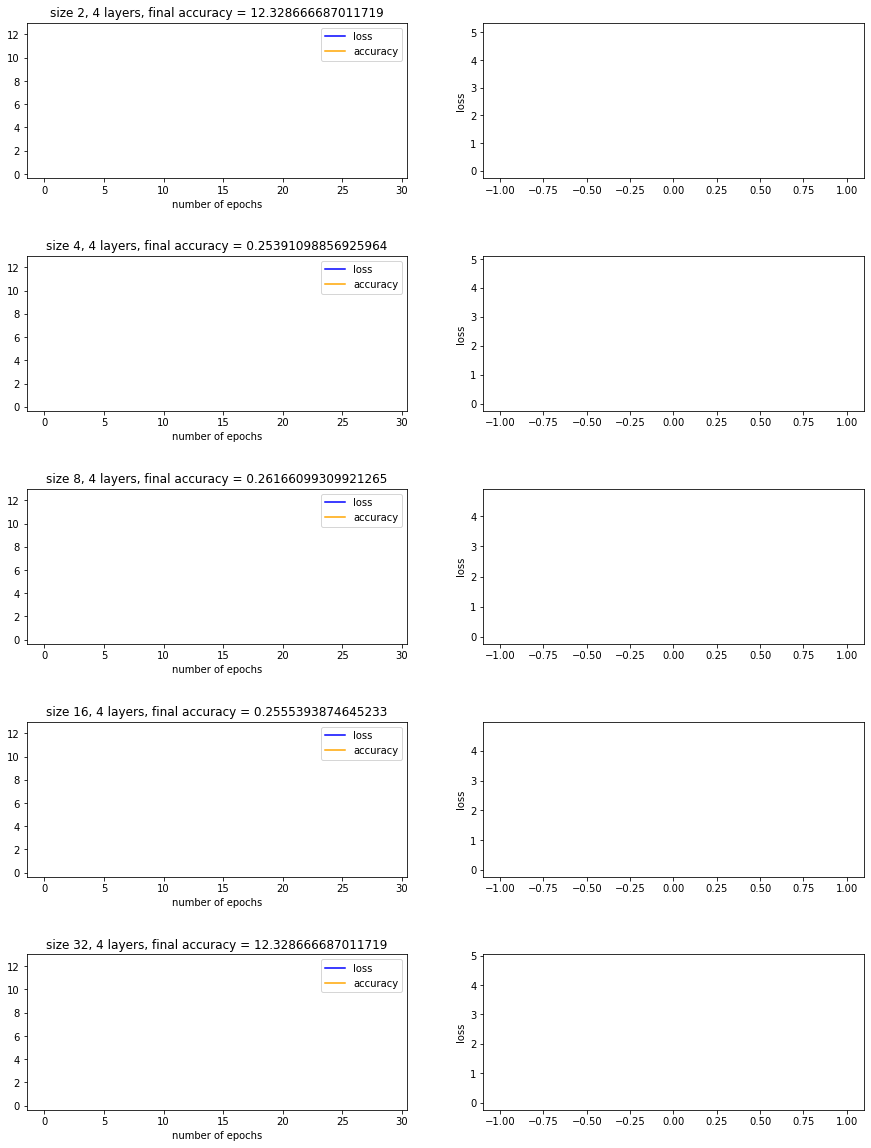

In [24]:
#plotting results

fig, axes = plt.subplots ( len (sizes), 2)
fig.set_size_inches (15, 4 * len (sizes))
plt.subplots_adjust (hspace=0.5)

for nhiddlayers, loss, val_loss, prediction in zip (depths, losses, val_losses, predictions):
    try:
        for size, lo, val_lo, pred, axx in zip ( sizes, loss, val_loss, prediction, axes ):
            axx [0].plot (range (len(lo)), lo, label="loss", color="blue")
            axx [0].plot (range (len(val_lo)), val_lo, label="accuracy", color="orange")
            axx [0].set_xlabel ("number of epochs")
            axx [1].set_ylabel ("loss")
            axx [0].set_title ("size " + str (size) + ", " + str (nhiddlayers) + 
                               " layers, final accuracy = " + str (val_lo [-1]))

            axx [0].legend()
            
            axx [1].scatter (datapol.xtest, polynomial (datapol.xtest, [a0,a1,a2,a3]), label="expected")
            axx [1].scatter (datapol.xtest, pred , label="predicted")
            #print ("predictions ", pred )
            
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(5)
        for axx in axes :
            axx [0].lines [1].remove()
            axx [0].lines [0].remove()
            
            axx [1].collections [1].remove()
            axx [1].collections [0].remove() 
            
    except KeyboardInterrupt:
        break
    



it can be seen from the plots above that an 8 nodes per layer - 2 layers or a 16 nodes per layer - 3 layers can do the job. after further sperimentation, a "best" model is composed in the cell below

In [29]:
# composing a model. 

model_pol = tf.keras.Sequential()
model_pol.add (Dense (8, input_shape=(1,), activation=activations.relu))
model_pol.add (Dense (16, activation=activations.relu))
model_pol.add (Dense (8, activation=activations.relu))
model_pol.add (Dense (1, activation=activations.relu))

model_pol.save_weights ("model_pol")





Now we try using different optimizers. We choose SGD because it is the sipmlest one, plus Adam and RMSprop which should be an enhanced version of it

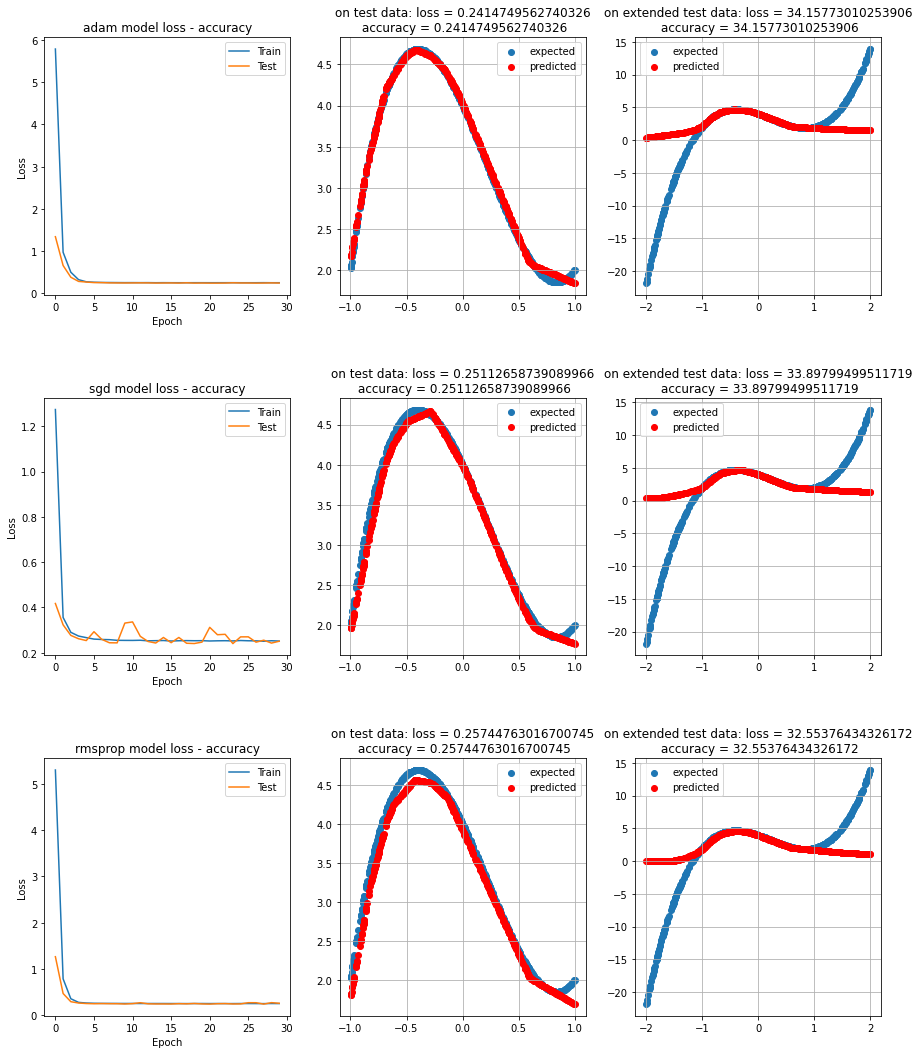

In [30]:
optnames = ["adam", "sgd", "rmsprop"]

fig, axes = plt.subplots (len (optnames), 3)
fig.set_size_inches (15, 6 * len (optnames))
plt.subplots_adjust (hspace=0.4)


for axx, optname in zip (axes, optnames):
    model_pol.compile (optimizer=optname , loss='mse', metrics=['mse'])
    model_pol.load_weights ("model_pol")
    # fit the model using training dataset
    # over 10 epochs of 32 batch size each
    # report training progress against validation data
    history = model_pol.fit(x=datapol.xtrain, y=datapol.ytrain, 
              batch_size=32, epochs=30,
              shuffle=True, # a good idea is to shuffle input before at each epoch
              validation_data=(datapol.xtest, datapol.ytest), verbose=0)
    # evaluate model
    score = model_pol.evaluate(datapol.xtest, datapol.ytest, batch_size=32, verbose=0)
    extendedScore = model_pol.evaluate (newx_test, newy_test, batch_size=32, verbose=0) 

    # look into training history
    # Plot training & validation loss values
    axx [0].plot(history.history['loss'])
    axx [0].plot(history.history['val_loss'])
    axx [0].set_title( optname + ' model loss - accuracy')
    axx [0].set_ylabel('Loss')
    axx [0].set_xlabel('Epoch')
    axx [0].legend(['Train', 'Test'], loc='best')

    #comparing predictions with expectations
    axx [1].scatter(datapol.xtest, polynomial (datapol.xtest, [a0,a1,a2,a3]), label="expected")
    axx [1].scatter(datapol.xtest, model_pol.predict (datapol.xtest) ,color='r', label="predicted")
    axx [1].set_title( "on test data: loss = " + str(score [0]) + "\n accuracy = " + str(score [1]) )
    axx [1].legend()
    axx [1].grid(True)

    
    axx [2].scatter(newx_test, newy_test, label="expected")
    axx [2].scatter(newx_test, model_pol.predict (newx_test) ,color='r', label="predicted")
    axx [2].set_title( "on extended test data: loss = " + str(extendedScore [0]) + "\n accuracy = " + str(extendedScore [1]) )
    axx [2].legend()
    axx [2].grid(True)



It can be noticed that both Adam and RMSprop algorithms achieve about the same accuracy than the stocastic gradient descent. The main difference between the former methods and the latter shows up in how accuracy varies over the number of epochs: with sgd it does not vary in a regular way, whereas for the Adam and RMSprops algorithms accuracy always vraries smoothly. None of the methods achieves a significant accuracy in predictiong data outside of the training data interval. For subsequent analysis, Adam algorithm shall be kept

Now we try choosing different activation functions: "relu", "selu", which rely on similar principles, "exp", and a saturating function, "tanh"

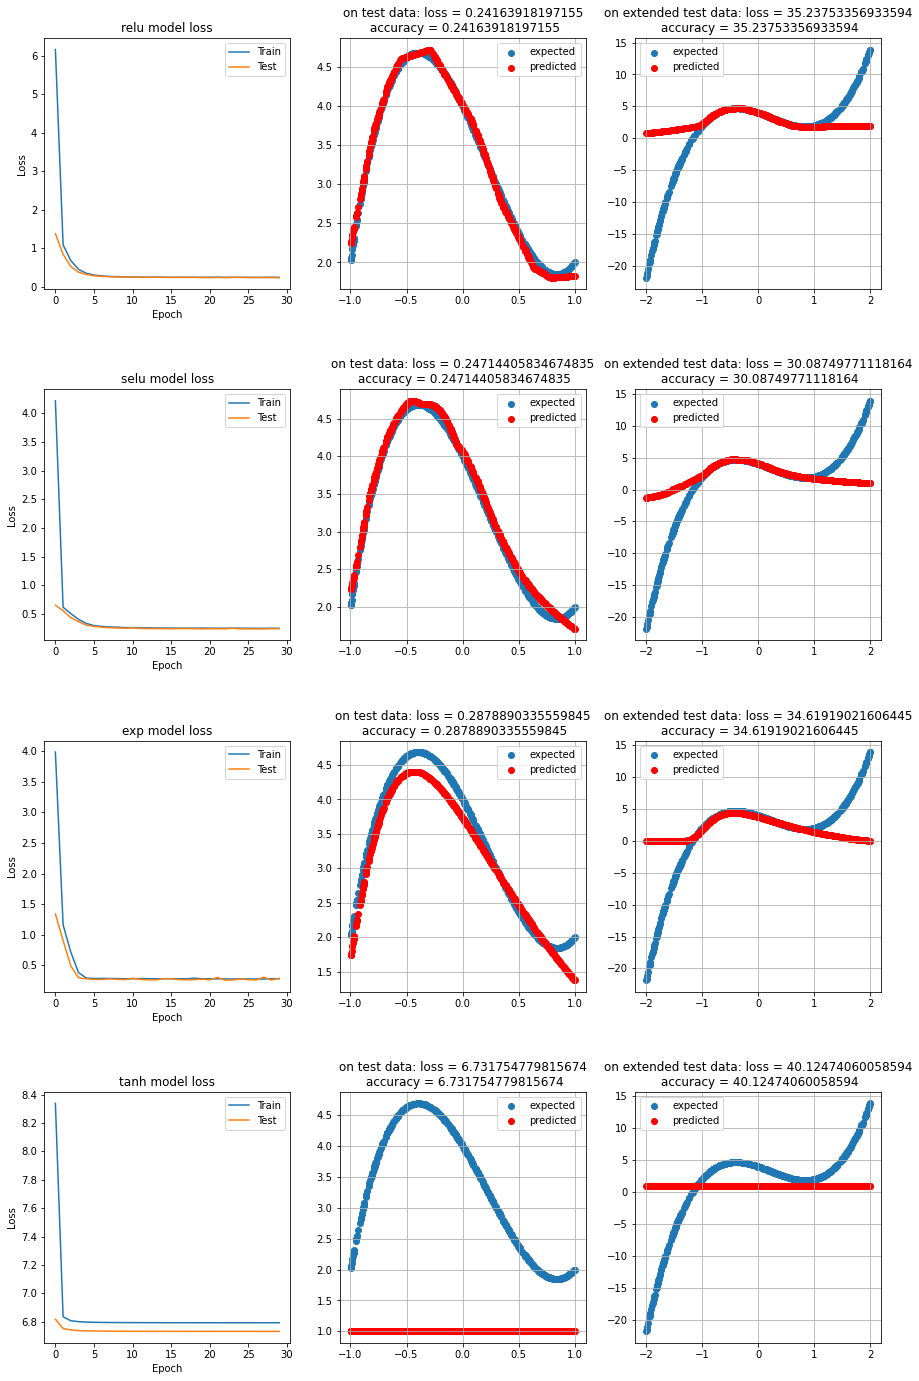

In [26]:
actnames = {
    "relu" : activations.relu, 
    "selu" : activations.selu, 
    "exp" : activations.exponential, 
    "tanh" :activations.tanh
}

fig, axes = plt.subplots (len (actnames), 3)
fig.set_size_inches (15, 6 * len (actnames))
plt.subplots_adjust (hspace=0.4)


for axx, (actname, act)  in zip (axes, actnames.items() ):
    
    model_pol = tf.keras.Sequential()
    model_pol.add (Dense (8, input_shape=(1,), activation=act))
    model_pol.add (Dense (16, activation=act))
    model_pol.add (Dense (8, activation=act))
    model_pol.add (Dense (1, activation=act))
   
    model_pol.compile (optimizer="adam" , loss='mse', metrics=['mse'])
    model_pol.load_weights ("model_pol")
    # fit the model using training dataset
    # over 10 epochs of 32 batch size each
    # report training progress against validation data
    history = model_pol.fit(x=datapol.xtrain, y=datapol.ytrain, 
              batch_size=32, epochs=30,
              shuffle=True, # a good idea is to shuffle input before at each epoch
              validation_data=(datapol.xtest, datapol.ytest), verbose=0)
    # evaluate model
    score = model_pol.evaluate(datapol.xtest, datapol.ytest, batch_size=32, verbose=0)
    extendedScore = model_pol.evaluate (newx_test, newy_test, batch_size=32, verbose=0) 


    # look into training history
    # Plot training & validation loss values
    axx [0].plot(history.history['loss'])
    axx [0].plot(history.history['val_loss'])
    axx [0].set_title( actname + ' model loss')
    axx [0].set_ylabel('Loss')
    axx [0].set_xlabel('Epoch')
    axx [0].legend(['Train', 'Test'], loc='best')

    #comparing predictions with expectations
    axx [1].scatter(datapol.xtest, polynomial (datapol.xtest, [a0,a1,a2,a3]), label="expected")
    axx [1].scatter(datapol.xtest, model_pol.predict (datapol.xtest) ,color='r', label="predicted")
    axx [1].set_title( "on test data: loss = " + str(score [0]) + "\n accuracy = " + str(score [1]) )
    axx [1].legend()
    axx [1].grid(True)

    axx [2].scatter(newx_test, newy_test, label="expected")
    axx [2].scatter(newx_test, model_pol.predict (newx_test) ,color='r', label="predicted")
    axx [2].set_title( "on extended test data: loss = " + str(extendedScore [0]) + "\n accuracy = " + str(extendedScore [1]) )
    axx [2].legend()
    axx [2].grid(True)





"relu" function wins (even thought a good fit is obtained with "selu" too, and the predictions obtained after training with this activation match slightly better the extended data). anyway, "relu" will be kept in the following. It is worth noticing that saturating function do not proof effective in training the model

Finally, we test several loss functions: mean square error, mean absolute error, percentage error (which actually should not proof extremely useful in this context), and Huber, which is told to combine the advantages of both MSE and MSA

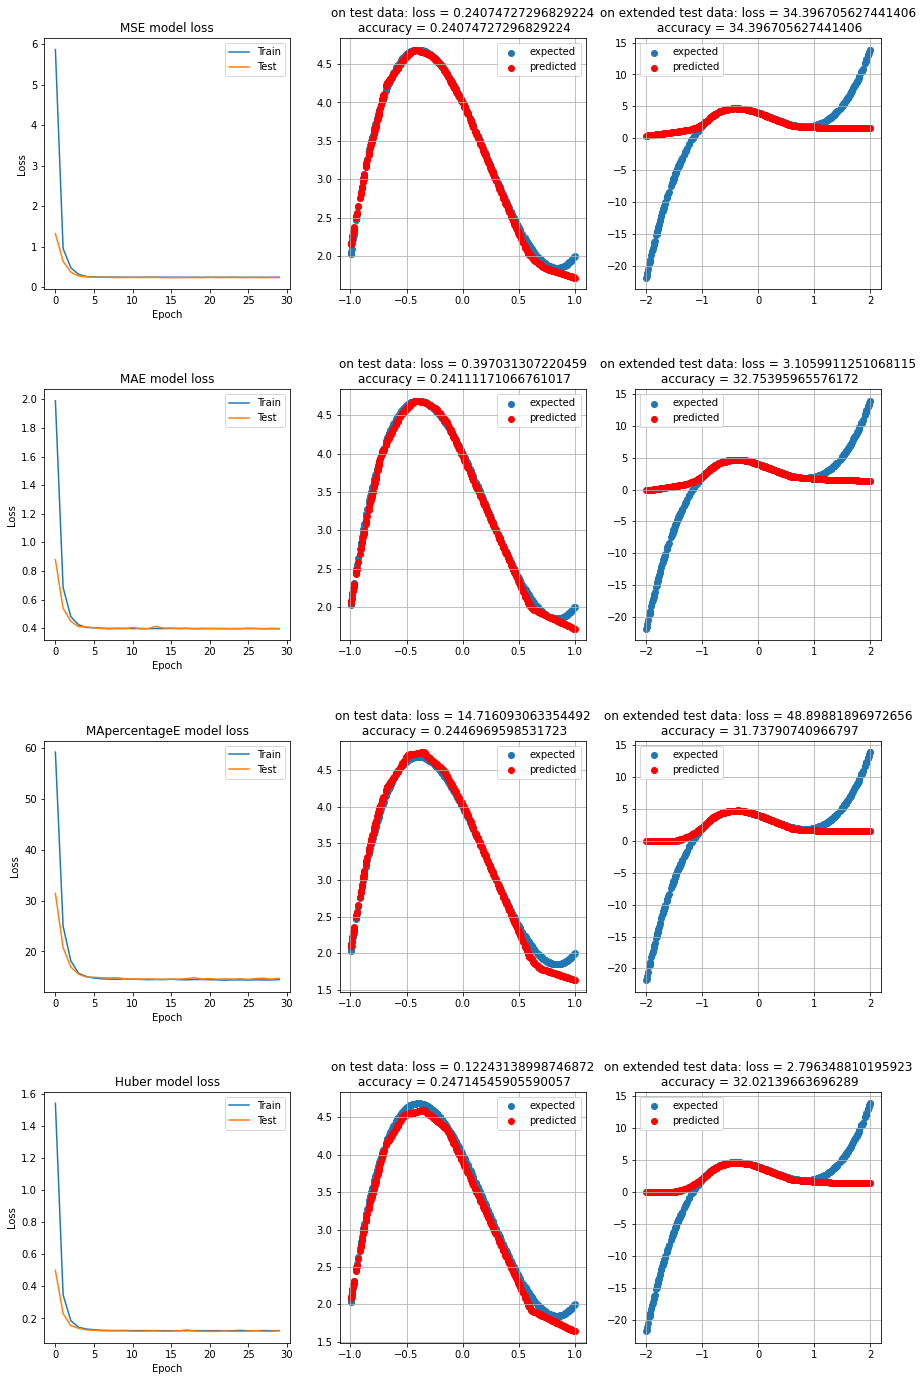

In [33]:
lossnames = {
    "MSE" : keras.losses.MeanSquaredError(), 
    "MAE" : keras.losses.MeanAbsoluteError(), 
    "MApercentageE" : keras.losses.MeanAbsolutePercentageError(), 
    "Huber" : keras.losses.Huber ()
}

fig, axes = plt.subplots (len (lossnames), 3)
fig.set_size_inches (15, 6 * len (lossnames))
plt.subplots_adjust (hspace=0.4)


for axx, (lossname, loss)  in zip (axes, lossnames.items() ):
    
    model_pol = tf.keras.Sequential()
    model_pol.add (Dense (8, input_shape=(1,), activation="relu"))
    model_pol.add (Dense (16, activation="relu"))
    model_pol.add (Dense (8, activation="relu"))
    model_pol.add (Dense (1, activation="relu"))
   
    model_pol.compile (optimizer="adam" , loss=loss , metrics=['mse'])
    model_pol.load_weights ("model_pol")
    # fit the model using training dataset
    # over 10 epochs of 32 batch size each
    # report training progress against validation data
    history = model_pol.fit(x=datapol.xtrain, y=datapol.ytrain, 
              batch_size=32, epochs=30,
              shuffle=True, # a good idea is to shuffle input before at each epoch
              validation_data=(datapol.xtest, datapol.ytest), verbose=0)
    # evaluate model
    score = model_pol.evaluate(datapol.xtest, datapol.ytest, batch_size=32, verbose=0)
    extendedScore = model_pol.evaluate (newx_test, newy_test, batch_size=32, verbose=0) 


    # look into training history
    # Plot training & validation loss values
    axx [0].plot(history.history['loss'])
    axx [0].plot(history.history['val_loss'])
    axx [0].set_title( lossname + ' model loss')
    axx [0].set_ylabel('Loss')
    axx [0].set_xlabel('Epoch')
    axx [0].legend(['Train', 'Test'], loc='best')

    #comparing predictions with expectations
    axx [1].scatter(datapol.xtest, polynomial (datapol.xtest, [a0,a1,a2,a3]), label="expected")
    axx [1].scatter(datapol.xtest, model_pol.predict (datapol.xtest) ,color='r', label="predicted")
    axx [1].set_title( "on test data: loss = " + str(score [0]) + "\n accuracy = " + str(score [1]) )
    axx [1].legend()
    axx [1].grid(True)

    axx [2].scatter(newx_test, newy_test, label="expected")
    axx [2].scatter(newx_test, model_pol.predict (newx_test) ,color='r', label="predicted")
    axx [2].set_title( "on extended test data: loss = " + str(extendedScore [0]) + "\n accuracy = " + str(extendedScore [1]) )
    axx [2].legend()
    axx [2].grid(True)

No loss function performs significantly better than the others. For simplicity, the MSE loss function will be chosen for the next part of the exercise. 

In conclusion, the most important choiche is that of the layout of the model, which also determines whether it can be trained at all (too rich  a structure may crash training if data are scarce). Once an enough rich network was set up, almost all reasonable training choiches (egs non-saturating activations ) performed well. 

None of the trained models could predict points outside the initial range satisfactorily. This behaviour was not completely unexpected, since the tested models are very simple and the function values outside the data range are very much different from those within. Probably a very large network is necessary for that purpose

<h5>11-3: extend yuor model in order to fit a $\mathbb{R}^2 \to \mathbb{R}$ trigonometric function <h5>

We start by defining a multiple variable function to produce the training and test data 

In [25]:
def sin2d (x, parameters=None):
    return np.sin(x[0]**2 + x[1]**2)

datasin = FunctionData( sin2d, None, [-3/2,3/2], 5000, 500, noise_sigma=0.5, ndims=2)

from mpl_toolkits import mplot3d


Next we create a model with the parameters selected in 11-2, only we change input_shape in the frist layer so that it accepts 2 values data (x and y coordinate), and we plot the training statistics and final predictions 

In [28]:
%matplotlib notebook

fig = plt.figure ()
fig.set_size_inches (9, 4)


ax = fig.add_subplot (121)
ax3d = fig.add_subplot (122, projection='3d')

#print (datasin.xtest.shape)
#print (sin2d (datasin.xtest).shape)

X = datasin.xtest[0]
Y = datasin.xtest[1]

Z = sin2d (datasin.xtest)

exppoints = ax3d.scatter (X, Y, Z, color = "green", label="expected")


x = y = np.arange (-1.5, 1.5, 0.2)
x, y = np.meshgrid (x, y)

z = sin2d ([x,y])

#surf = ax3d.plot_surface(x,y,z, cmap=plt.cm.coolwarm,
                      # linewidth=0 )
    
    
x_train = datasin.xtrain.transpose()
x_test = datasin.xtest.transpose()

#print (x_train)

earlystop = tf.keras.callbacks.EarlyStopping (monitor='val_loss', patience=7)

model_sin = tf.keras.Sequential()
model_sin.add (Dense (8, input_shape=(2,), activation="relu"))
model_sin.add (Dense (16, activation="relu"))
model_sin.add (Dense (8, activation="relu"))
model_sin.add (Dense (1, activation="relu"))

model_sin.compile (optimizer="adam" , loss='mse', metrics=['mse'])
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
history = model_sin.fit(x=x_train , y=datasin.ytrain, 
          batch_size=32, epochs=400,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(x_test, datasin.ytest), verbose=0,
        callbacks = [earlystop])
# evaluate model
score = model_sin.evaluate(x_test, datasin.ytest, batch_size=32, verbose=0)



# look into training history
# Plot training & validation loss values
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title( ' model loss: final values: loss = ' + str(score [0]) + "\n accuracy = " + str(score [1]) )
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='best')





#comparing predictions with expectations
z_predicted = model_sin.predict(datasin.xtest.transpose())
plot3d = ax3d.scatter (datasin.xtest[0], datasin.xtest[1], z_predicted ,color='r', label="predicted")
ax3d.legend ()


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

An early stopping callback has been added to the previous training routine because the model converges slowlier than the previous ones, so it is not clear a priori how many epochs should be set.